In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import emoji
import datetime
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Twitter Dataset

### Dataset Exploration

In [2]:
twitter = pd.read_excel("twitter.xlsx")
twitter.head()

,title,content,from,locatiion,date,images,url,by,likes,shares
0,NaN,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,Bengaluru,2022-11-08 10:40:56,[],https://twitter.com/mykhelcom/status/158981016...,myKhel.com,0,0
1,NaN,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,"Mumbai, India",2022-11-08 10:58:55,[],https://twitter.com/republic/status/1589814697...,Republic,10,1
2,NaN,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,Worldwide,2022-11-08 11:08:09,[],https://twitter.com/CarbonCreditRes/status/158...,Carbon Credit Research,0,0
3,NaN,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,Worldwide,2022-11-08 12:00:50,[],https://twitter.com/viralposthq/status/1589830...,Viral Cyprus,0,0
4,NaN,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,NaN,2022-12-18 16:21:57,[],https://twitter.com/MrX__NFT/status/1604391505...,MrX_NFT,0,0


In [3]:
twitter = twitter.drop_duplicates() #Eliminates duplicate values
twitter = twitter.drop(columns=["title", "images", "url", "by", "locatiion"]) #Erasing columns

new_column_names = {
    "from": "Publisher",
    "date": "Date",
    "likes": "Likes",
    "shares": "Shares"
}
twitter = twitter.rename(columns=new_column_names)

In [4]:
twitter['Date'] = twitter['Date'].dt.date #Convert to ymd

twitter.head()

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,2022-11-08,0,0
1,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,2022-11-08,10,1
2,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,2022-12-18,0,0


### Dataset Analysis

In [5]:
twitter.dtypes

content      object
Publisher    object
Date         object
Likes         int64
Shares        int64
dtype: object

In [6]:
twitter['content'] = twitter['content'].astype(str)

In [7]:
twitter.describe()

,Likes,Shares
count,27508.000000,27508.000000
mean,186.251854,45.223971
std,4939.797974,1552.419537
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,3.000000,1.000000
max,629808.000000,236759.000000


In [8]:
#Likes distribution

likes_percentiles = twitter["Likes"].describe(percentiles=[.50, .60, .70, .75, .80, .85, .90, .95, .96, .97, .98, .99, .995, .999])
print(likes_percentiles)

count     27508.000000
mean        186.251854
std        4939.797974
min           0.000000
50%           0.000000
60%           1.000000
70%           2.000000
75%           3.000000
80%           5.000000
85%          10.000000
90%          23.000000
95%          75.000000
96%         109.720000
97%         174.790000
98%         347.000000
99%        1307.670000
99.5%      4133.905000
99.9%     43192.497000
max      629808.000000
Name: Likes, dtype: float64


In [9]:
#Shares distribution

shares_percentiles = twitter["Shares"].describe(percentiles=[.50, .75, .85, .90, .95, .96, .97, .98, .99, .995, .999])
print(shares_percentiles)

count     27508.000000
mean         45.223971
std        1552.419537
min           0.000000
50%           0.000000
75%           1.000000
85%           3.000000
90%           7.000000
95%          23.000000
96%          34.000000
97%          52.000000
98%         102.000000
99%         482.930000
99.5%      1381.000000
99.9%      7717.000000
max      236759.000000
Name: Shares, dtype: float64


In [10]:
publisher_counts = twitter['Publisher'].value_counts()

publisher_counts.head(10)

Gulf-Times              342
The Voice of America    121
beIN SPORTS             107
Robbie Sparkes           98
#YFM                     89
Metro                    83
AFP news agency          78
Sky News                 73
Andy Vermaut             56
AP Sports                53
Name: Publisher, dtype: int64

In [11]:
date_counts = twitter['Date'].value_counts()

date_counts

2022-11-21    2802
2022-11-20    1909
2022-11-19    1329
2022-11-18    1089
2022-11-22     998
              ... 
2023-01-04       4
2023-01-08       3
2023-01-09       3
2023-01-07       2
2023-01-06       1
Name: Date, Length: 92, dtype: int64

In [12]:
twitter['content'].duplicated().sum()

159

In [13]:
twitter = twitter.drop_duplicates(subset='content', keep=False)

twitter

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,2022-11-08,0,0
1,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,2022-11-08,10,1
2,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFA World Cup 2022: Sometimes things don’t go...,Daily News hunt 24,2022-11-28,0,0
27504,⚽️ FIFA World Cup Qatar 2022 Match schedule:⚽️...,K8 Official,2022-11-29,5,1
27505,Please am I only one that has not yet watched ...,Anas zurmi,2022-11-29,5,0
27506,This is what the #FIFAWorldCup is all about;\n...,FIFA World Cup Stats,2022-11-28,124,28


In [14]:
twitter.duplicated().sum()

0

In [15]:
twitter.isna().sum()

content      0
Publisher    2
Date         0
Likes        0
Shares       0
dtype: int64

In [16]:
twitter_sort = twitter.sort_values(by=['Likes'], ascending=False)

twitter_sort.head()

,content,Publisher,Date,Likes,Shares
11760,방탄소년단 ‘정국’이 2022 FIFA 카타르 월드컵 공식 사운드트랙과 월드컵 개막...,BTS_official,2022-11-12,629808,236759
21390,It’s the end for Cristiano Ronaldo at the Worl...,Fabrizio Romano,2022-12-11,231247,27972
25127,"Lionel Messi: “No, I’m NOT gonna retire from t...",Fabrizio Romano,2022-12-19,184694,16489
11710,"�️ Abdullah Al Nasari, Head of Security at the...",Football Tweet ⚽,2022-11-12,149618,27087
10593,Outrageously disrespectful to Qatar that the B...,Piers Morgan,2022-11-21,133871,21023


In [17]:
twitter_sort = twitter.sort_values(by=['Shares'], ascending=False)

twitter_sort.head()

,content,Publisher,Date,Likes,Shares
11760,방탄소년단 ‘정국’이 2022 FIFA 카타르 월드컵 공식 사운드트랙과 월드컵 개막...,BTS_official,2022-11-12,629808,236759
10585,Jungkook of BTS and Qatari singer Fahad Al Kub...,The Peninsula Qatar,2022-11-20,127116,53379
21390,It’s the end for Cristiano Ronaldo at the Worl...,Fabrizio Romano,2022-12-11,231247,27972
11710,"�️ Abdullah Al Nasari, Head of Security at the...",Football Tweet ⚽,2022-11-12,149618,27087
10593,Outrageously disrespectful to Qatar that the B...,Piers Morgan,2022-11-21,133871,21023


### NLTK Package

In [18]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

twitter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/farrelw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/farrelw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,2022-11-08,0,0
1,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,2022-11-08,10,1
2,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFA World Cup 2022: Sometimes things don’t go...,Daily News hunt 24,2022-11-28,0,0
27504,⚽️ FIFA World Cup Qatar 2022 Match schedule:⚽️...,K8 Official,2022-11-29,5,1
27505,Please am I only one that has not yet watched ...,Anas zurmi,2022-11-29,5,0
27506,This is what the #FIFAWorldCup is all about;\n...,FIFA World Cup Stats,2022-11-28,124,28


In [19]:
#Eliminates stopwords

twitter['content'] = twitter['content'].apply(lambda text: ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words]))

twitter

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful World Cup inclusion En...,myKhel.com,2022-11-08,0,0
1,Qatar promises 'carbon-neutral ' FIFA World Cu...,Republic,2022-11-08,10,1
2,Qatar 's promise 'carbon-neutral ' World Cup r...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned Stadiums Qa...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day ! . Argentina win 2-...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFA World Cup 2022 : Sometimes things ’ go wa...,Daily News hunt 24,2022-11-28,0,0
27504,⚽️ FIFA World Cup Qatar 2022 Match schedule : ...,K8 Official,2022-11-29,5,1
27505,Please one yet watched even single match Qatar...,Anas zurmi,2022-11-29,5,0
27506,# FIFAWorldCup ; � playing street football big...,FIFA World Cup Stats,2022-11-28,124,28


In [20]:
#Remove emojis

df_emoji = pd.DataFrame(twitter)
def remove_emojis(twitter):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',twitter)
df_emoji.content=df_emoji['content'].apply(remove_emojis)
df_emoji

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful World Cup inclusion En...,myKhel.com,2022-11-08,0,0
1,Qatar promises 'carbon-neutral ' FIFA World Cu...,Republic,2022-11-08,10,1
2,Qatar 's promise 'carbon-neutral ' World Cup r...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned Stadiums Qa...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day ! . Argentina win 2-...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFA World Cup 2022 : Sometimes things ’ go wa...,Daily News hunt 24,2022-11-28,0,0
27504,FIFA World Cup Qatar 2022 Match schedule : E...,K8 Official,2022-11-29,5,1
27505,Please one yet watched even single match Qatar...,Anas zurmi,2022-11-29,5,0
27506,# FIFAWorldCup ; playing street football bigg...,FIFA World Cup Stats,2022-11-28,124,28


In [21]:
#Lemmatization

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Assuming verbs
    return ' '.join(lemmatized_words)

twitter['content'] = twitter['content'].apply(lemmatize_text)

twitter

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful World Cup inclusion En...,myKhel.com,2022-11-08,0,0
1,Qatar promise 'carbon-neutral ' FIFA World Cup...,Republic,2022-11-08,10,1
2,Qatar 's promise 'carbon-neutral ' World Cup r...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned Stadiums Qa...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day ! . Argentina win 2-...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFA World Cup 2022 : Sometimes things ’ go wa...,Daily News hunt 24,2022-11-28,0,0
27504,FIFA World Cup Qatar 2022 Match schedule : Ecu...,K8 Official,2022-11-29,5,1
27505,Please one yet watch even single match Qatar W...,Anas zurmi,2022-11-29,5,0
27506,# FIFAWorldCup ; play street football biggest ...,FIFA World Cup Stats,2022-11-28,124,28


In [22]:
'''
#Tokenizes words

twitter['content'] = twitter['content'].apply(word_tokenize)

twitter
'''

"\n#Tokenizes words\n\ntwitter['content'] = twitter['content'].apply(word_tokenize)\n\ntwitter\n"

In [23]:
#Remove punctuation marks

def remove_punctuation(text):
    return re.sub(r'[^\w\s#]', '', text)

twitter['content'] = twitter['content'].apply(remove_punctuation)
twitter

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful World Cup inclusion En...,myKhel.com,2022-11-08,0,0
1,Qatar promise carbonneutral FIFA World Cup cl...,Republic,2022-11-08,10,1
2,Qatar s promise carbonneutral World Cup raise...,Carbon Credit Research,2022-11-08,0,0
3,Around 6000 Argentine Fans Banned Stadiums Qat...,Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day Argentina win 21 #...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFA World Cup 2022 Sometimes things go way ...,Daily News hunt 24,2022-11-28,0,0
27504,FIFA World Cup Qatar 2022 Match schedule Ecua...,K8 Official,2022-11-29,5,1
27505,Please one yet watch even single match Qatar W...,Anas zurmi,2022-11-29,5,0
27506,# FIFAWorldCup play street football biggest s...,FIFA World Cup Stats,2022-11-28,124,28


In [24]:
def remove_characters(text):
    characters_to_remove = ["``", "`", "'", "’", "“", "'s", "�"]
    for char in characters_to_remove:
        text = text.replace(char, '')
    return text

def remove_standalone_s(text):
    return re.sub(r'\bs\b', ' ', text)

def merge_hashtags(text):
    return re.sub(r'#\s', '#', text)

twitter['content'] = twitter['content'].apply(remove_characters)
twitter['content'] = twitter['content'].apply(remove_standalone_s)
twitter['content'] = twitter['content'].apply(merge_hashtags)

twitter['content'] = twitter['content'].str.replace('FIFA World Cup', 'FIFAWorldCup')
twitter['content'] = twitter['content'].str.replace('World Cup', 'WorldCup')
twitter = twitter[twitter['content'].apply(lambda tokens: 'RT' not in tokens)]

twitter

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful WorldCup inclusion Eng...,myKhel.com,2022-11-08,0,0
1,Qatar promise carbonneutral FIFAWorldCup clim...,Republic,2022-11-08,10,1
2,Qatar promise carbonneutral WorldCup raise ...,Carbon Credit Research,2022-11-08,0,0
3,Around 6000 Argentine Fans Banned Stadiums Qat...,Viral Cyprus,2022-11-08,0,0
4,Happy WorldCup Final Day Argentina win 21 #M...,MrX_NFT,2022-12-18,0,0
...,...,...,...,...,...
27503,FIFAWorldCup 2022 Sometimes things go way wa...,Daily News hunt 24,2022-11-28,0,0
27504,FIFAWorldCup Qatar 2022 Match schedule Ecuado...,K8 Official,2022-11-29,5,1
27505,Please one yet watch even single match Qatar W...,Anas zurmi,2022-11-29,5,0
27506,#FIFAWorldCup play street football biggest st...,FIFA World Cup Stats,2022-11-28,124,28


### Data Analysis

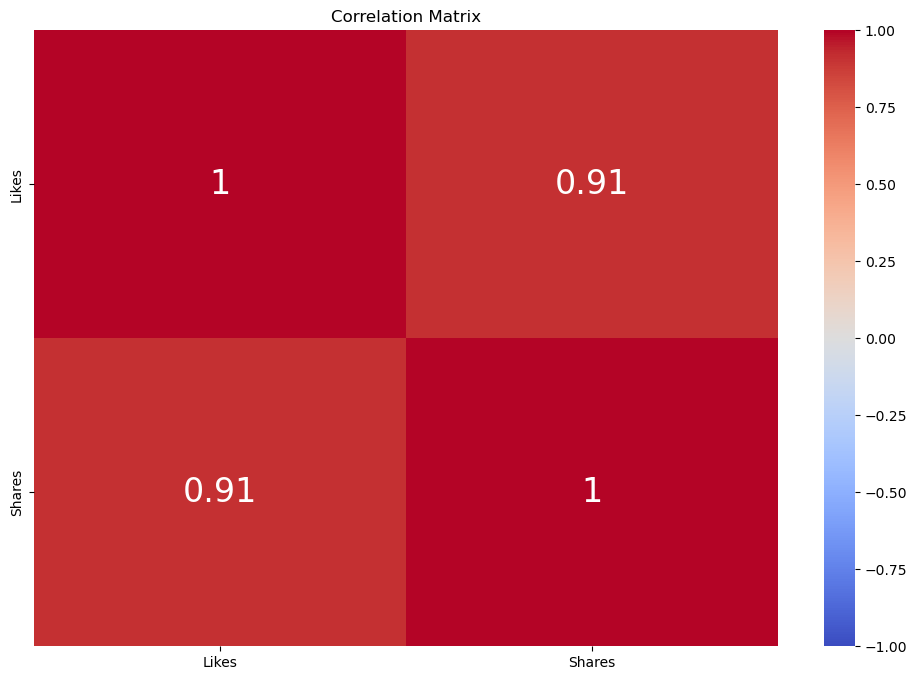

In [41]:
correlation_matrix = twitter.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 24})
plt.title("Correlation Matrix")
plt.show()

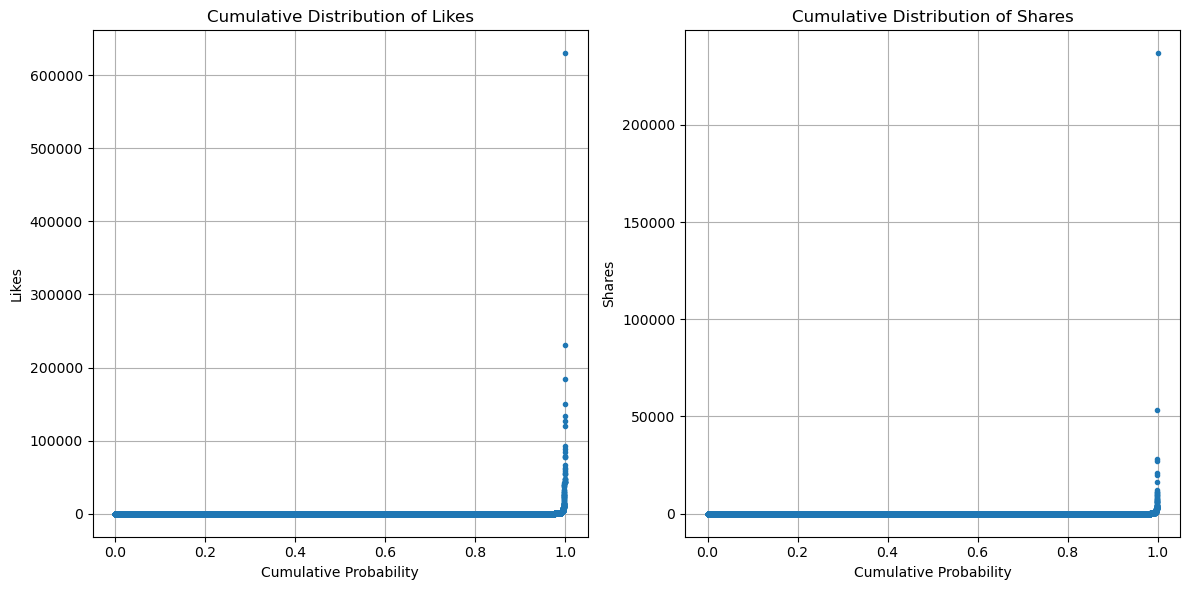

In [48]:
likes_data = twitter["Likes"]
shares_data = twitter["Shares"]

likes_data_sorted = likes_data.sort_values()
shares_data_sorted = shares_data.sort_values()

n = len(likes_data_sorted)
cumulative_distribution_likes = np.arange(1, n + 1) / n
cumulative_distribution_shares = np.arange(1, n + 1) / n

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_distribution_likes, likes_data_sorted, marker='.', linestyle='none')
plt.title("Cumulative Distribution of Likes")
plt.xlabel("Cumulative Probability")
plt.ylabel("Likes")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_distribution_shares, shares_data_sorted, marker='.', linestyle='none')
plt.title("Cumulative Distribution of Shares")
plt.xlabel("Cumulative Probability")
plt.ylabel("Shares")
plt.grid(True)

plt.tight_layout()
plt.show()

In [52]:
#Likes distribution

likes_percentiles = twitter["Likes"].describe(percentiles=[.50, .60, .70, .80, .90, .95, .99, .995, .999])
print(likes_percentiles)

count     26591.000000
mean        191.871648
std        5023.884582
min           0.000000
50%           0.000000
60%           1.000000
70%           2.000000
80%           5.000000
90%          24.000000
95%          77.000000
99%        1346.700000
99.5%      4184.550000
99.9%     43435.830000
max      629808.000000
Name: Likes, dtype: float64


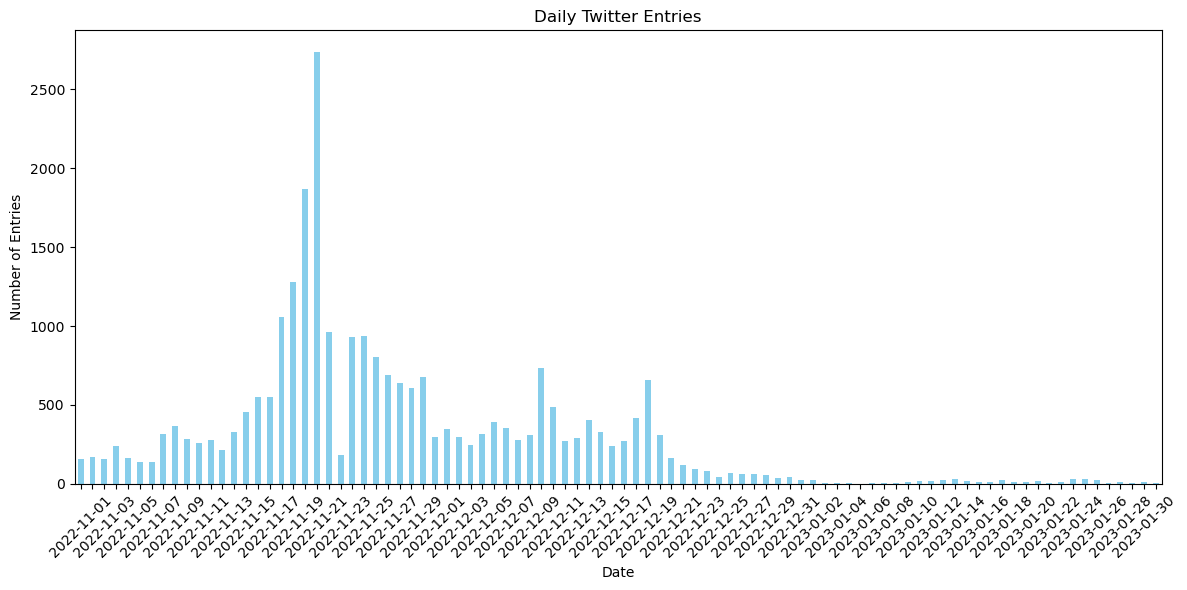

In [71]:
daily_entry_counts = twitter.groupby(twitter["Date"].dt.date).size()

plt.figure(figsize=(12, 6))
daily_entry_counts.plot(kind="bar", color="skyblue")
plt.title("Daily Twitter Entries")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.xticks(rotation=45)

x_labels = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels):
    if i % 2 != 0:
        label.set_visible(False)
plt.tight_layout()
plt.show()

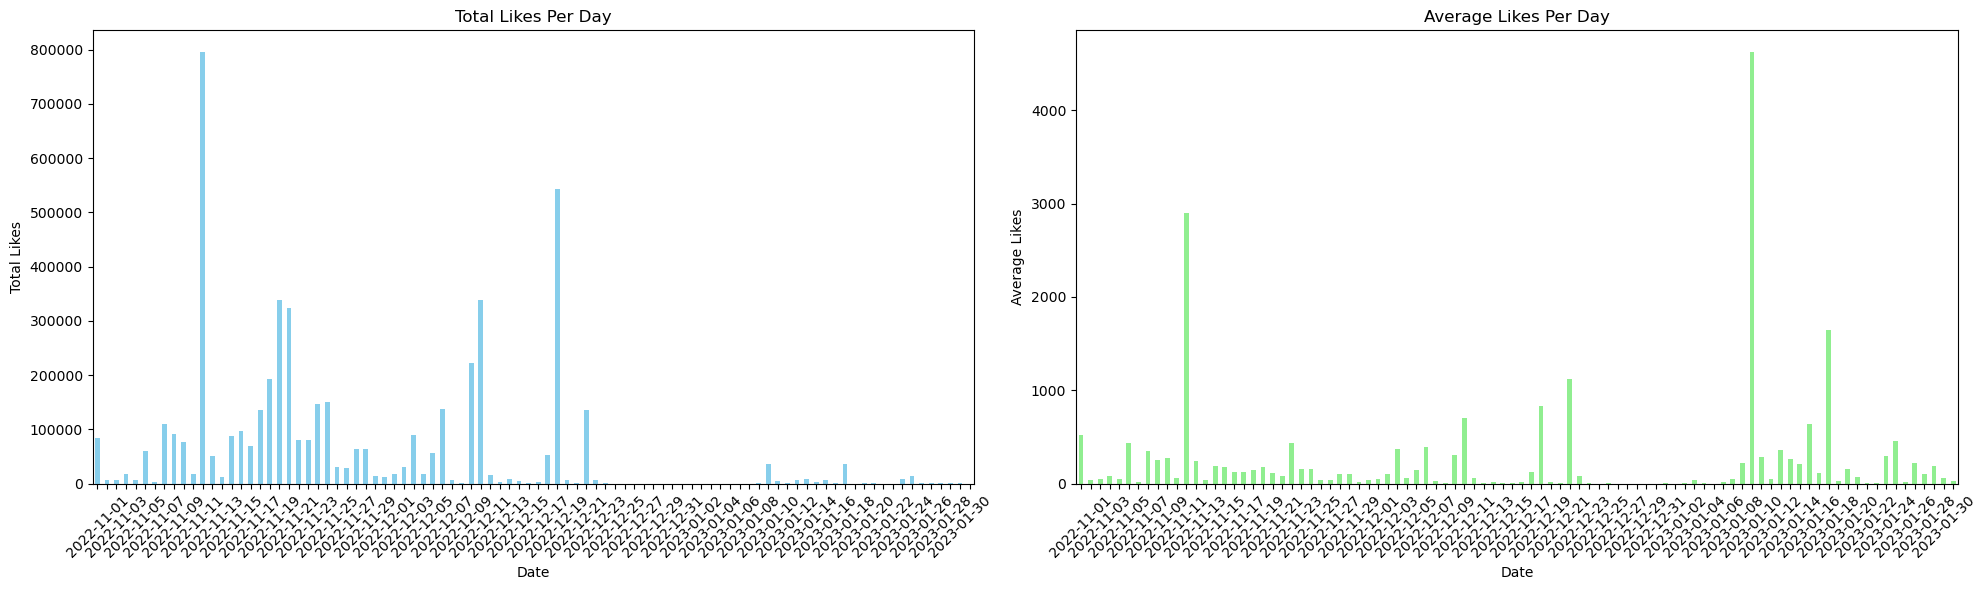

In [78]:
total_likes_per_day = twitter.groupby(twitter["Date"].dt.date)["Likes"].sum()
average_likes_per_day = twitter.groupby(twitter["Date"].dt.date)["Likes"].mean()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

total_likes_per_day.plot(kind="bar", color="skyblue")
plt.title("Total Likes Per Day")
plt.xlabel("Date")
plt.ylabel("Total Likes")
plt.xticks(rotation=45)

x_labels_total = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_total):
    if i % 2 != 0:
        label.set_visible(False)

plt.subplot(1, 2, 2)

average_likes_per_day.plot(kind="bar", color="lightgreen")
plt.title("Average Likes Per Day")
plt.xlabel("Date")
plt.ylabel("Average Likes")
plt.xticks(rotation=45)

x_labels_average = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_average):
    if i % 2 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()

### Custom Dataset

In [ ]:
twitter

In [ ]:
twitter['Date'] = pd.to_datetime(twitter['Date'])

pre_tournament = twitter[twitter['Date'] < '2022-11-20']
tournament = twitter[(twitter['Date'] >= '2022-11-20') & (twitter['Date'] <= '2022-12-18')]
post_tournament = twitter[twitter['Date'] > '2022-12-18']

pre_tournament = pd.DataFrame(pre_tournament)
tournament = pd.DataFrame(tournament)
post_tournament = pd.DataFrame(post_tournament)

In [ ]:
pre_tournament['Date'] = pd.to_datetime(pre_tournament['Date'])

pre_tournament_sorted = pre_tournament.sort_values(by=['Date', 'Likes'], ascending=[True, False])

pre_tournament_likes = pre_tournament_sorted.groupby('Date').head(3)

pre_tournament_likes.head()

In [ ]:
pre_tournament['Date'] = pd.to_datetime(pre_tournament['Date'])

pre_tournament_sorted = pre_tournament.sort_values(by=['Date', 'Shares'], ascending=[True, False])

pre_tournament_shares = pre_tournament_sorted.groupby('Date').head(3)

pre_tournament_shares.head()

In [ ]:
tournament['Date'] = pd.to_datetime(tournament['Date'])

tournament_sorted = tournament.sort_values(by=['Date', 'Likes'], ascending=[True, False])

tournament_likes = tournament_sorted.groupby('Date').head(3)

tournament_likes.head()

In [ ]:
tournament['Date'] = pd.to_datetime(tournament['Date'])

tournament_sorted = tournament.sort_values(by=['Date', 'Shares'], ascending=[True, False])

tournament_shares = tournament_sorted.groupby('Date').head(3)

tournament_shares.head()

In [ ]:
post_tournament['Date'] = pd.to_datetime(post_tournament['Date'])

post_tournament_sorted = post_tournament.sort_values(by=['Date', 'Likes'], ascending=[True, False])

post_tournament_likes = post_tournament_sorted.groupby('Date').head(3)

post_tournament_likes.head()

In [ ]:
post_tournament['Date'] = pd.to_datetime(post_tournament['Date'])

post_tournament_sorted = post_tournament.sort_values(by=['Date', 'Shares'], ascending=[True, False])

post_tournament_shares = post_tournament_sorted.groupby('Date').head(3)

post_tournament_shares.head()

## Player Analysis

In [ ]:
# Count how often 'messi' appears in the 'content' column
count_messi = twitter['content'].str.contains('messi', case=False).sum()

# Display the count
print("Number of times 'messi' appears:", count_messi)

In [ ]:
messi_entries = twitter[twitter['content'].str.contains('messi', case=False)]

# Display the entries
messi_entries.head(50)

In [ ]:
player_df = pd.read_csv("player_stats.csv")

player_df = player_df[['player']]
player_df

In [ ]:
players = player_df['player'].tolist()

In [ ]:
surnames = [' '.join(names.split()[1:]) if len(names.split()) > 1 else names for names in players]
surnames = [string.lower() for string in surnames]

In [ ]:
all_words = twitter['content'].str.split().explode().tolist()

In [ ]:
surname_counts = {}

for surname in surnames:
    count = sum(1 for word in all_words if surname in word.lower())
    surname_counts[surname] = count

In [ ]:
word_counts = Counter(surname_counts)

In [ ]:
sorted_surnames = sorted(surnames, key=lambda word: word_counts.get(word, 0), reverse=True)

print("Most trending player:", sorted_surnames[0])
print("Number of mentions:", word_counts[sorted_surnames[0]])

In [ ]:
count = 0
for i in all_words:
    if i == "visit":
        count += 1
print(count)

In [ ]:
top_trenders = sorted_surnames[0:10]

In [ ]:
name_mentions = []
for i in range(10):
    name_mentions.append(word_counts[sorted_surnames[i]])

name_mentions

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 6))
plt.bar(top_trenders, name_mentions)
plt.xlabel("Player Last Name")
plt.ylabel("Number of times mentioned")
plt.show()

## Team Analysis

In [ ]:
team_df = pd.read_csv("player_stats.csv")

team = team_df[['team']]
team

In [ ]:
unique_teams = team['team'].unique()
unique_teams = [team.replace('IR Iran', 'Iran').replace('Korea Republic', 'Korea').replace('Saudi Arabia', 'Saudi').replace('Costa Rica', 'Costa').replace('United States', 'USA') for team in unique_teams]
unique_teams

### Pre-Tournament

In [ ]:
team_counts = {team: 0 for team in unique_teams}

for team in unique_teams:
    team_counts[team] = pre_tournament['content'].str.count(team.lower()).sum()

In [ ]:
sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[0:10]
top_10_counts = list(sorted_team_counts.values())[0:10]

plt.figure(figsize=(12, 6))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Pre-Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Tournament

In [ ]:
start_date = '2022-11-20'
end_date = '2022-12-18'

filtered_tournament = tournament[(tournament['Date'] >= start_date) & (tournament['Date'] <= end_date)]

team_counts = {team: 0 for team in unique_teams}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in unique_teams:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(12, 6))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Overall Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
start_date = '2022-11-20'
end_date = '2022-12-2'

filtered_tournament = tournament[(tournament['Date'] >= start_date) & (tournament['Date'] <= end_date)]

team_counts = {team: 0 for team in unique_teams}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in unique_teams:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(12, 6))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Overall Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
start_date = '2022-12-3'
end_date = '2022-12-7'

teams_of_interest = ['Netherlands', 'USA', 'Argentina', 'Australia', 'Japan', 'Croatia', 
                    'Brazil', 'Korea', 'England', 'Senegal', 'France', 'Poland', 'Morocco',
                    'Spain', 'Portugal', 'Switzerland']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

RO16_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
RO16_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(RO16_teams, RO16_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('RO16 Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
start_date = '2022-12-9'
end_date = '2022-12-11'

teams_of_interest = ['Netherlands', 'Argentina', 'Croatia', 'Brazil', 'England', 'France', 'Morocco', 'Portugal']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

QF_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
QF_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(QF_teams, QF_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('QF Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
start_date = '2022-12-13'
end_date = '2022-12-15'

teams_of_interest = ['Argentina', 'Croatia', 'France', 'Morocco']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

SF_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
SF_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(SF_teams, SF_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('SF Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Post-Tournament

In [ ]:
team_counts = {team: 0 for team in unique_teams}

for team in unique_teams:
    team_counts[team] = post_tournament['content'].str.count(team.lower()).sum()

In [ ]:
sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(12, 6))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Post-Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
'''
GS1: 20/11 - 24/11
GS2: 25/11 - 28/11
GS3: 29/11 - 2/12
RO16: 3/12 - 6/12
QF: 9/12 - 10/12
SF: 13/12 - 14/12
3P: 17/12
F: 18/12
'''

### Sentiment Analysis

In [ ]:
nltk.download('movie_reviews')
nltk.download('vader_lexicon')

In [ ]:
# Create a function to get sentiment polarity using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'content' column and store the results in a new column 'sentiment_score'
twitter['sentiment_score'] = twitter['content'].apply(get_sentiment)

In [ ]:
twitter_ss = twitter.iloc[:, [0,5,1,2,3,4]]
twitter_ss.head(27507)

In [ ]:
twitter_ss = twitter.sort_values(by=['sentiment_score'])
twitter_ss.head(27507)

In [ ]:
unique_teams

In [ ]:
average_sentiment_scores = {'Country': [], 'Average_Sentiment_Score': []}

for country in unique_teams:
    country_data = twitter[twitter['content'].str.contains(country, case=False)]
    
    average_sentiment_score = country_data['sentiment_score'].mean()
    
    average_sentiment_scores['Country'].append(country)
    average_sentiment_scores['Average_Sentiment_Score'].append(average_sentiment_score)

average_sentiment_df = pd.DataFrame(average_sentiment_scores)

In [ ]:
average_sentiment_df = average_sentiment_df.sort_values(by='Average_Sentiment_Score', ascending=False)
average_sentiment_df = average_sentiment_df.reset_index(drop=True)

average_sentiment_df